In [87]:
%%capture
!rm -r spaan
!git clone https://github.com/nicolagulmini/spaan
!pip install Bio

from spaan.data_processing import *
from spaan.Expanded_SPAAN_Model import *
from Bio import SeqIO
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAXLEN = 100
# to determine in a smarter way
np.random.seed(42)

In [91]:
# load the datasets (about 1 minute)
positive = list(SeqIO.parse("spaan/data/original_adh_dataset.fasta", "fasta"))
negative = list(SeqIO.parse("spaan/data/original_negative_dataset.fasta", "fasta"))

aa_list = [
    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'
    ]

def seq_to_ind(seq):
    ind_seq = []
    for aa in seq:
        ind_seq.append(aa_list.index(aa)+1)
    return pad_sequences([ind_seq], maxlen=MAXLEN, padding='post', truncating='post')[0]

def process(positive_ds, negative_ds):
    # data processing
    x, y = [], []

    for protein in positive_ds:
        tmp = [
                    aminoacids_frequencies(protein.seq),
                    multiplet_frequencies(protein.seq, 3),
                    multiplet_frequencies(protein.seq, 4),
                    multiplet_frequencies(protein.seq, 5),
                    dipeptide_frequencies(protein.seq),
                    charge_composition(protein.seq),
                    hydrophobic_composition(protein.seq),
                    seq_to_ind(protein.seq)
        ]
        cond = 1
        for el in tmp:
            if isinstance(el, int):
                cond = 0
        if cond == 1:
            for el in tmp:
                for entry in el:
                    if (entry == float("inf") or entry == float("-inf")):
                        cond = 0
                        break
        if cond == 1:
            x.append(tmp)
            y.append(1)
        
    for protein in negative_ds:
        tmp = [
                    aminoacids_frequencies(protein.seq),
                    multiplet_frequencies(protein.seq, 3),
                    multiplet_frequencies(protein.seq, 4),
                    multiplet_frequencies(protein.seq, 5),
                    dipeptide_frequencies(protein.seq),
                    charge_composition(protein.seq),
                    hydrophobic_composition(protein.seq),
                    seq_to_ind(protein.seq)
        ]
        cond = 1
        for el in tmp:
            if isinstance(el, int):
                cond = 0
        if cond == 1:
            for el in tmp:
                for entry in el:
                    if (entry == float("inf") or entry == float("-inf")):
                        cond = 0
                        break
        if cond == 1:
            x.append(tmp)
            y.append(0)
    return x, y

x, y = process(positive, negative)

In [92]:
x_train, y_train, x_val, y_val, x_test, y_test = split_ds(np.array(x), np.array(y), np.random.permutation(len(x)))
# fix the warning of the nested lists!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [111]:
import tensorflow
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding

class LSpaanTModule:
    
    def __init__(self):

        # LSTM module
        LSTM_module_input = Input(shape=(MAXLEN))
        LSTM_module_embed = Embedding(21, 32)(LSTM_module_input) # cause we have 20 aminoacids
        LSTM_layer = LSTM(64, dropout=.1)(LSTM_module_embed)
        LSTM_final_dense = Dense(1, activation='sigmoid')(LSTM_layer)

        # model 1
        aa_freq = Input(shape=(20))
        dense_1 = Dense(30, activation='sigmoid')(aa_freq)
        inter_dense = Dense(20, activation='sigmoid')(dense_1)
        dropout_1 = Dropout(.2)(inter_dense)
        dense_1_2 = Dense(1, activation='sigmoid')(dropout_1)
        
        # model 2.1
        multiplet_freq_1 = Input(shape=(20))
        dense_2_1_1 = Dense(28, activation='sigmoid')(multiplet_freq_1)
        inter_dense_2 = Dense(20, activation='sigmoid')(dense_2_1_1)
        dense_2_1_2 = Dense(1, activation='sigmoid')(inter_dense_2)
        # model 2.2
        multiplet_freq_2 = Input(shape=(20))
        dense_2_2_1 = Dense(28, activation='sigmoid')(multiplet_freq_2)
        inter_dense_3 = Dense(20, activation='sigmoid')(dense_2_2_1)
        dense_2_2_2 = Dense(1, activation='sigmoid')(inter_dense_3)
        # model 2.3
        multiplet_freq_3 = Input(shape=(20))
        dense_2_3_1 = Dense(28, activation='sigmoid')(multiplet_freq_3)
        inter_dense_4 = Dense(20, activation='sigmoid')(dense_2_3_1)
        dense_2_3_2 = Dense(1, activation='sigmoid')(inter_dense_4)
        # concatenate outputs
        concat_1 = Concatenate()([dense_2_1_2, dense_2_2_2, dense_2_3_2])
        inter_dense_concat = Dense(20)(concat_1)
        dropout_2 = Dropout(.2)(inter_dense_concat)
        dense_2_4 = Dense(1, activation='sigmoid')(dropout_2)
        
        # model 3
        dipept_freq = Input(shape=(400))
        dense_3 = Dense(500, activation='sigmoid')(dipept_freq)
        inter_dense_5 = Dense(100, activation='sigmoid')(dense_3)
        dropout_3 = Dropout(.2)(inter_dense_5)
        dense_3_2 = Dense(1, activation='sigmoid')(dropout_3)
        
        # model 4
        charge_comp = Input(shape=(15))
        dense_4 = Dense(30, activation='sigmoid')(charge_comp)
        inter_dense_6 = Dense(20, activation='sigmoid')(dense_4)
        dropout_4 = Dropout(.2)(inter_dense_6)
        dense_4_2 = Dense(1, activation='sigmoid')(dropout_4)
        
        # model 5
        hydrophob_comp = Input(shape=(50))
        dense_5 = Dense(40, activation='sigmoid')(hydrophob_comp)
        inter_dense_7 = Dense(20, activation='sigmoid')(dense_5)
        dropout_5 = Dropout(.2)(inter_dense_7)
        dense_5_2 = Dense(1, activation='sigmoid')(dropout_5)
        
        # final concatenation
        concat_2 = Concatenate()([dense_1_2, dense_2_4, dense_3_2, dense_4_2, dense_5_2, LSTM_final_dense])
        final_inter_dense = Dense(20)(concat_2)
        dropout_final = Dropout(.1)(final_inter_dense)
        final_dense = Dense(1, activation='sigmoid')(dropout_final)
        
        model = Model(inputs=[aa_freq, multiplet_freq_1, multiplet_freq_2, multiplet_freq_3, dipept_freq, charge_comp, hydrophob_comp, LSTM_module_input], outputs=final_dense)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics='accuracy')
        
        self.model = model
        
    def get_model(self):
        return self.model

In [112]:
# method for fitting in the multi-input neural network
def fit_in_NN(x):
    x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8 = [[] for _ in range(8)]
    for el in x:
        x_1.append(el[0])
        x_2.append(el[1])
        x_3.append(el[2])
        x_4.append(el[3])
        x_5.append(el[4])
        x_6.append(el[5])
        x_7.append(el[6])
        x_8.append(el[7])
    return np.array(x_1), np.array(x_2), np.array(x_3), np.array(x_4), np.array(x_5), np.array(x_6), np.array(x_7), np.array(x_8)

In [113]:
# model instantiation
espaan_model = LSpaanTModule()
max_epochs = 1000

In [114]:
history = espaan_model.get_model().fit(
                                        x=fit_in_NN(x_train),
                                        y=y_train,
                                        batch_size=32, 
                                        epochs=300, # the original paper has 10k epochs!
                                        verbose=1, # 1 or 2 to watch the evolution
                                        validation_data=(fit_in_NN(x_val), y_val),
                                        #callbacks=[tensorflow.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                                        shuffle=True    
                                        )

Epoch 1/300
18/18 [==============================] - 6s 127ms/step - loss: 0.7203 - accuracy: 0.4929 - val_loss: 0.6717 - val_accuracy: 0.6050
Epoch 2/300
18/18 [==============================] - 1s 82ms/step - loss: 0.6765 - accuracy: 0.5996 - val_loss: 0.6751 - val_accuracy: 0.6050
Epoch 3/300
18/18 [==============================] - 1s 80ms/step - loss: 0.6774 - accuracy: 0.6014 - val_loss: 0.6710 - val_accuracy: 0.6050
Epoch 4/300
18/18 [==============================] - 1s 80ms/step - loss: 0.6753 - accuracy: 0.5996 - val_loss: 0.6714 - val_accuracy: 0.6050
Epoch 5/300
18/18 [==============================] - 1s 81ms/step - loss: 0.6799 - accuracy: 0.5925 - val_loss: 0.6709 - val_accuracy: 0.6050
Epoch 6/300
18/18 [==============================] - 1s 83ms/step - loss: 0.6791 - accuracy: 0.5996 - val_loss: 0.6708 - val_accuracy: 0.6050
Epoch 7/300
18/18 [==============================] - 1s 79ms/step - loss: 0.6778 - accuracy: 0.5996 - val_loss: 0.6707 - val_accuracy: 0.6050
Epoch

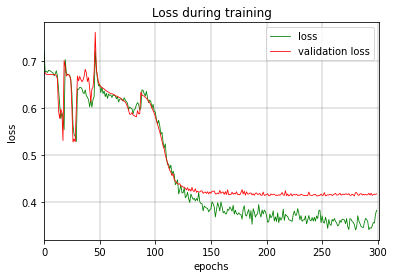

In [115]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='loss', ls='-', linewidth=.8, color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', ls='-', linewidth=.8, color='red')
plt.grid(color='grey', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0, len(history.history['loss'])+1)
plt.savefig('loss.png')
plt.show()

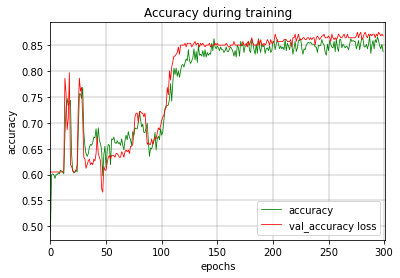

In [116]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='accuracy', ls='-', linewidth=.8, color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='val_accuracy loss', ls='-', linewidth=.8, color='red')
plt.grid(color='grey', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.savefig('acc.png')
plt.show()

In [118]:
print("Test accuracy: " + str(espaan_model.get_model().evaluate(
    x=fit_in_NN(x_test),
    y=y_test   
    )[1]))

9/9 [==============================] - 0s 26ms/step - loss: 0.3101 - accuracy: 0.8830
Test accuracy: 0.8829787373542786


In [119]:
espaan_model.get_model().save('LSTM_model.h5')